# Prueba técnica de Marvik

A continuación se encuentra un ejemplo práctico del uso de Deep Learning, utilizando Keras y Tensorflow.

---


## Predicción de series ordenadas en el tiempo

En este proyecto se hará una predicción de una serie ordenada en el tiempo usando un regresor RNN (Recurrent Neural Network regressor).

Se hará una predicción del precio de la acción de Apple con 7 días de anticipación, en base a una serie histórica.

Se hará uso de una arquitectura para el RNN conocida como [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory).

Las RNN generalmente están hechas para **tratar con secuencias de algún tipo**, secuencias en el tiempo quizás como hacer predicciones de los precios de las acciones a lo largo del tiempo o simplemente cosas que tienen algún orden. Así, por ejemplo, se puede utilizar una RNN para la traducción automática. Un par de conceptos claves en este tipo de redes son las **LSTN (Long Short Term Memory)**, y GRU (Gated Recurrent Unit).


La particularidad en este tipo de redes es que la salida de una neurona en un paso de tiempo se retroalimenta como entrada en el siguiente paso, lo que permite que la red tenga una "memoria" con respecto a los estados anteriores. Es por esta razón que es especialmente útil para la predicción de series de tiempo. Durante el entrenamiento, las RNN ajustan sus pesos utilizando algoritmos como **Backpropagation Through Time** (BPTT), permitiendo que la red aprenda tanto dependencias tanto a largo como a corto plazo en los datos.


Una limitación importante de las RNN es su incapacidad para encontrar dependencias a largo plazo debido al problema de los "vanishing gradientes". Esto ocurre cuando el error entre las salidas de la red y los datos reales se propagan mal hacia atrás a través de la red y tienden a no afectar las primeras capas de la red. A su vez los valores de gradiente bajos hacen que no se produzca la actualización de los pesos de la red y por lo tanto que las predicciones sean inexactas. Lo opuesto, el "exploding gradient", también puede ser una limitación de los RNN al tratar con dependencias a largo plazo. Sin embargo, esto podría mitigarse utilizando la técnica de recorte de gradiente (gradient clipping technique), que consiste en imponer un límite máximo a los valores de gradiente y evitar desbordamientos numéricos en los valores de pesos.


Para abordar el problema del "vanishing gradient" de las RNN, (Cho, Van Merriënboer, Bahdanau y Bengio, 2014) y (Chung, Gucehre, Cho y Bengio, 2014) propusieron unidades recurrentes cerradas (GRU). La principal mejora en comparación con los RNN es la introducción de una celda de memoria que arrastrará, a través de la red, dependencias a largo plazo de secuencias anteriores y mitigará el problema del gradiente que "desaparece".


Una versión del modelo de secuencia construido sobre GRU son las LTSM. Estos modelos introducen dos mecanismos adicionales que hacen que el proceso de aprendizaje sea más flexible: las puertas de "olvido" y de "salida". La puerta del "olvido" decide qué información de la celda de memoria anterior debe ser eliminada o mantenida. Toma la entrada actual y el estado oculto anterior y produce un valor entre 0 y 1 para cada número en la celda de memoria, donde 1 significa "mantener toda esta información" y 0 significa "olvidar toda esta información". La puerta de "salida" controla qué parte de la información almacenada en la celda de memoria debe ser utilizada para la salida actual.Combina la entrada actual y el estado oculto anterior para decidir qué información de la celda de memoria debe pasar a la siguiente capa, quedándose así con la información más relevante.


LSTM, tiene la ventaja sobre la arquitectura de red neuronal simple por su capacidad de encontrar secuencias actuales y anteriores para producir pronósticos. Además, el modelado de este tipo de red no necesita que el conjunto de datos de entrada sea estacionario, como lo requieren los modelos de tipo ARIMA.




Fuente: https://arxiv.org/pdf/2101.03087


### Parte 1: Primeros pasos
Primero se debe cargar una serie histórica. Cargaremos una serie con el precio de la acción de Apple de 140 días. Luego se hará un pre-procesamiento para utilizar la información con un modelo de una RNN. Como primer paso se normalizó el rango la serie. Esto ayuda a evitar grandes problemas numéricos asociados a como las funciones de activación como tanh transforman números muy grandes (sean positivos o negativos) y ayuda a evitar problemas con el cálculo de las derivadas.

Se normaliza la serie para que pertenezca al rango [-1,1] [usando esta función de la librería scikit](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). También es común ver aplicaciones donde se normaliza utilizando la desviación estándar.


##### Cómo funciona Min-Max Scaler y porqué utilizarlo
Min-Max Scaler es una de las funciones disponibles en la librería de Scikit Learn que tiene la. ventaja de mantener la forma y la estrucutra de la distribución original de los datos. Esto es fundamental cuando estamos trabajando con series de teimpo ya que los datos contienen infomración importante sobre tendencia y patrones temporales. Además puede mejorar la convergencia y eficiencia de los algoritmos de optimización. Los gradientes calculados son más consistentes y pueden ayudar a mejorar la velocidad de entrenamiento.
Particularmente en funciones de activación como tanh se da porque esta transforma cualquier numero en un rango entre -1 y 1. Cuando los números son extremadamente grandes, la salida puede volverse muy cercana a 1 o -1, provocando la saturación de la función. Esto también puede llevar a que la salida sea muy grande y se produzca el problema del "exploding gradient" que hace que los pesos de la red se actualicen de manera exagerada dificultando la convergencia del modelo.

In [ ]:
### Cargar las librerías necesarias para el cargado de los datos y la normalización
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random

import tensorflow as tf


# Clonar repositorio con los datos en espacio de trabajo
! git clone https://bitbucket.org/botiaio/campusparty_applestock.git

Cloning into 'campusparty_applestock'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 1.77 KiB | 1.77 MiB/s, done.


In [ ]:
# Establecer la semilla aleatoria
seed_value = 102
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

In [ ]:
### Cargar los datos normalizados
dataset = np.loadtxt('campusparty_applestock/normalized_apple_prices.csv')

In [ ]:
print(f'Contamos con una serie de {len(dataset)} valores.')

Contamos con una serie de 138 valores.


Observemos los datos cargados

Text(0, 0.5, 'serie normalizada')

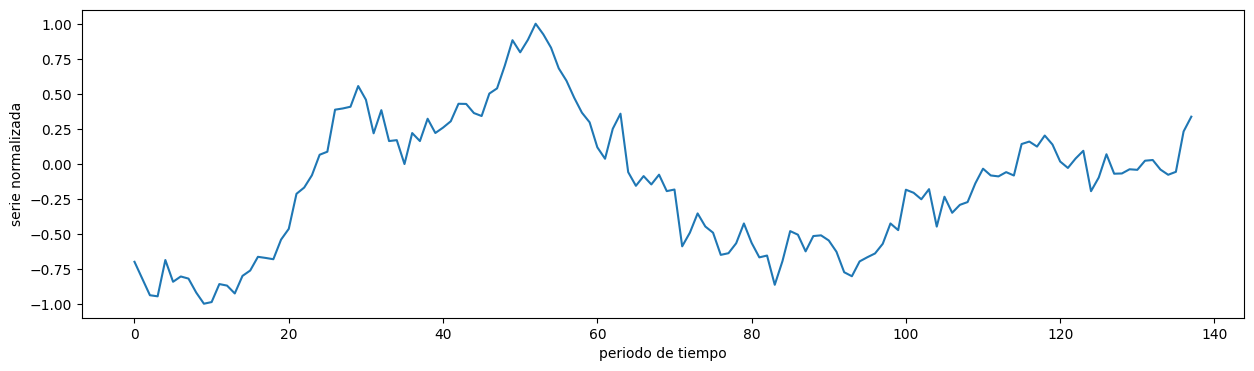

In [ ]:
#Grafiquemos los datos
plt.figure(figsize=(15, 4))
plt.plot(dataset)
plt.xlabel('periodo de tiempo')
plt.ylabel('serie normalizada')

### Parte 2: Cortar la serie ordenada en secuencias

Generalmente se representa matemáticamente una serie ordenada como:

$$s_{0},s_{1},s_{2},...,s_{P}$$


donde $s_{p}$ es el valor numérico de la serie en el intervalo de tiempo $p$ , siendo  $P$ el largo total de la serie. Para aplicar el RNN se debe tratar a la predicción como un problema de regresión. Para ello se debe usar una ventana móvil para construir un set asociado de pares de entrada-salida sobre los cuales aplicar la regresión.

Por ejemplo, para una ventana de tamaño T = 3 se deben producir los siguientes pares:

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3}\rangle} & \color{Goldenrod}{ s_{4}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4} \rangle } & \color{Goldenrod} {s_{5} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$


####Ventana móvil
Completar la función llamada **window_transform_series** que ejecuta una ventana móvil a lo largo de una serie de datos y crea los pares de input y output necesarios para el entrenamiento.

La función recibe la serie de datos y el tamaño de la ventana (3 en el ejemplo de arriba). Se debe retornar un numpy array.

Es necesario transformar el conjunto de datos en características y etiquetas para poder ajustar un modelo LSTM, tal como si fuéramos a resolver un problema de aprendizaje supervisado. Para lograr esto, se emplea una técnica llamada
"sliding window", que implica crear una ventana de tamaño fijo conocida como lookback. Esta ventana nos permite utilizar una cantidad fija de datos pasados como entrada para cada valor en el conjunto de datos.


In [ ]:
### @TODO: completar la función debajo que transforma los datos en los pares input-output necesarios dado el tamaño de la ventana
def window_transform_series(series, window_size):
    # Variables para los pares input-output
    X = []
    y = []

    # Creamos las windows
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])

    # Convertimos listas a arrays numpy
    X = np.array(X)
    y = np.array(y)

    # Shape al formato correcto
    X.shape = (np.shape(X)[0:2])
    y.shape = (len(y),1)

    return X, y

Se puede probar la función con los datos de debajo:

### Probar la función window_transform_series
A continuación probar el código recién programado. Puede ser sobre la serie de datos del problema o sobre otra serie de datos cuya secuencia sea conocida (por ejemplo Fibonacci).

#### Preuba en Serie Fibonacci
Para testear que hemos creado bien la función "window_transform_series" lo hacemos con la serie Fibonacci ya que visualmente es más fácil de comprobar que esté bien la implementación. La suma del input de cada celda debe ser igual al valor del output.


In [ ]:
# Generamos la serie de Fibonacci
def fibonacci_series(n):
    series = [0, 1]
    while len(series) < n:
        series.append(series[-1] + series[-2])
    return series

In [ ]:
### @TODO
# Utilizar una ventana de tamaño 2 y obtener el siguiente número de la serie
test_series = fibonacci_series(7)  # Generar los primeros 7 números de Fibonacci
window_size = 2
X, y = window_transform_series(test_series, window_size)

In [ ]:
print ('El input X es:')
print (X)

print ('El output y asociado es:')
print (y)

El input X es:
[[0 1]
 [1 1]
 [1 2]
 [2 3]
 [3 5]]
El output y asociado es:
[[1]
 [2]
 [3]
 [5]
 [8]]


Una vez que la función de arriba funcione correctamente, aplicarla con una ventana de tamaño 7 al juego de datos cargados.



#### Aplicamos window_transform_series en el dataset

In [ ]:
### @TODO
# Definir la variable window_size y usarla al invocar la función window_transform_series
window_size = 7
X,y = window_transform_series(dataset, window_size)

In [ ]:
dataset[:10]

array([-0.70062339, -0.82088484, -0.93938305, -0.9471652 , -0.68785527,
       -0.84325902, -0.80532018, -0.82058073, -0.92023124, -1.        ])

In [ ]:
print ('El input X es:')
print (X[:3])

print ('El output y asociado es:')
print (y[:3])

El input X es:
[[-0.70062339 -0.82088484 -0.93938305 -0.9471652  -0.68785527 -0.84325902
  -0.80532018]
 [-0.82088484 -0.93938305 -0.9471652  -0.68785527 -0.84325902 -0.80532018
  -0.82058073]
 [-0.93938305 -0.9471652  -0.68785527 -0.84325902 -0.80532018 -0.82058073
  -0.92023124]]
El output y asociado es:
[[-0.82058073]
 [-0.92023124]
 [-1.        ]]


###Parte 3: Separar los datos en datos de entrenamiento y de test
Se recomienda separar al menos un tercio de los datos para validación o test. Hacer eso a continuación. Aprovechar que es una serie ordenada y no hacer un split aleatorio de los datos para separar en test y train.

In [ ]:
### @TODO
# Separar los datos en entrenamiento y test
def train_test_split(X, y, train_size):
    split_index = int(len(X) * train_size)
    X_train = X[:split_index]
    y_train = y[:split_index]
    X_test = X[split_index:]
    y_test = y[split_index:]

    return X_train, X_test, y_train, y_test

In [ ]:
train_size = .7
X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size)

##### Formato de los datos para un RNN
En las redes neuronales recurrentes y particularmente en las LSTM, en Keras, es importante que el input tenga la forma [sample, windows_size, stepsize] ya que estas están preparadas para procesar datos secuenciales (series de tempo). Para capturar esas dependencias y las relaciones entre los diferentes pasos de una secuencia es esencial que los datos se representan de esta forma.
- Samples: representa el número de muestras en el conjunto de datos, la secuencia de datos de cada paso.
- windows size: indica el número de pasos de tiempo en cada muestra, en este caso 7. Esto define la secuencia temporal que la red LSTM procesará en un solo paso, ayudando a capturar dependencias a lo largo de esa longitud especificada.
- Stepsize: corresponde al número de características por cada paso de tiempo. En este caso va a ser 1 porque la red está configurada para procesar y aprender de cada punto en la secuencia temporal de manera individual, manteniendo así la estructura y el orden de los datos además de que tenemos una única característica, en este caso el precio de la acción.

In [ ]:
# IMPORTANTE: para utilizar el módulo RNN LSTM de Keras el input debe tener la forma [samples, window size, stepsize]
#Estas transformaciones se hacen a continuación
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

###Parte 4: Crear y ejecutar un modelo de regresión utilizando RNN

Se utilizará Keras para construir una red neuronal con dos capas ocultas RNN con las siguientes especificaciones:

* La capa 1 debe usar un módulo LSTM con 5 unidades ocultas (el input_shape de la misma debe ser (window_size,1))
* La capa 2 usa un módulo completamente conectado (fully connected) con una unidad
* Se debe usar la función de pérdida 'mean_squared_error'

Ayudas:

* [Documentación general de Keras](https://keras.io/getting-started/sequential-model-guide/)
* [Documentación de Keras de LTSM](https://keras.io/layers/recurrent/)
* Asegurarse de inicializar el [optimizador recomendado por Keras para RNN](https://keras.io/optimizers/)

#### Entendiendo la arquitectura de la red


Para resolver este problema se decide crear un modelo secuencial de forma incremental mediante el método add().


En la primera capa se utiliza el módulo **LSTM con 5 unidades ocultas**. Dentro de las Recurrent layers se encuentra la LSTM layer, por defecto tiene una función de activación tanh, y está diseñada para resolver este tipo de problemas. Algunos parámetros de esta layer son:


- units: Entero positivo, dimensionalidad del espacio de salida
- activation: Función de activación a utilizar. Valor predeterminado: tangente hiperbólica (tanh)


Las **units** hacen referencia al número de unidades o neuronas en esa capa en particular. Cada unidad en un capa LSTM representa una estructura interna que procesa y aprende patrones de secuencias temporales. Cuanta más unidades haya, más complejas pueden ser las relaciones que la red puede aprender de los datos secuenciales pero por otro lado es más costoso computacionalmente además de que puede llevar a un sobreajuste de los datos.


Hay muchos tipos distintos de funciones de activación entre los que elegir y escoger la correcta puede ser importante para el rendimiento de la red neuronal. Es la función dentro de un nodo o neurona, que suma todas las entradas a esa neurona y decide qué salida debe enviar a la siguiente capa de neuronas. La **función de activación** es básicamente la forma en que una neurona individual decide si su peso debe activar o no la propagación de esa señal. En el caso de LSTM la función de activación es la tangente hiperbólica.


Luego se le agrega una **capa densa**, llamada también Fully Connected Layer, esta se compone de un conjunto de neuronas completamente conectadas a todas las neuronas de la capa anterior. Cada unidad de esta capa realiza una combinación lineal de las salidas de la capa anterior, seguida de una función de activación. Este tipo de layers se suelen utilizar al final de un modelo. En este caso que utilizamos una de una unidad es porque queremos generar una única predicción continua una regresión simple. La capa densa toma la salida de LSTM y la transforma en una única salida.


En cuanto al **optimizador**, elegimos utilizar **Adam** con una taza de aprendizaje de 0.001. Adam es un optimizador que ajusta automáticamente la tasa de aprendizaje durante el entrenamiento. Esto es útil en este tipo de problemas en donde los datos pueden tener diferentes variabilidades ayudando a que converjan más rápido y de manera más estable. Además es eficiente en términos computacionales, ya que utiliza estimaciones de primer y segundo momento de los gradientes para ajustar los pesos de la red neuronal.
El primer momento actúa como una media móvil exponencial de los gradientes, permitiendo al optimizador moverse más rápidamente en la dirección del descenso de gradiente adecuado. Por otro lado, el segundo momento adapta la tasa de aprendizaje para cada parámetro en función de la variabilidad de los gradientes, asegurando una convergencia más estable y eficiente del modelo.


Se utiliza un **Learning Rate** bajo ya que si el ritmo de aprendizaje es demasiado alto, se podría sobrepasar la solución por completo, es decir se podría perder/saltear el punto inferior. Por lo tanto, una tasa de aprendizaje demasiado alta puede significar que me pase de la solución correcta por completo, pero una tasa de aprendizaje demasiado pequeña significa que mi entrenamiento puede durar más de lo necesario.


La **función de pérdida** elegida es el mean squared error, comúnmente utilizada en las regresiones y en particular para la evaluación de las predicciones en series de tiempo. Se calcula como el promedio de los errores de predicción al cuadrado. Utilizar el cuadrado de los valores los obliga a ser positivos pero también tiene el efecto de dar más importancia a los errores grandes.


In [ ]:
### @TODO: Crear el modelo RNN
# Importar librerías de Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

import keras

#Crear el modelo secuencial
model = Sequential()
#Agregar una capa LSTM con 5 unidades ocultas y el input shape necesario
model.add(LSTM(5, input_shape=(window_size, 1)))
#Agregar una capa densa con una unidad
model.add(Dense(1))

# Crear el modelo utilizando el optimizador recomendado por la documentación de keras
optimizer = Adam(learning_rate=0.001)

# Compilar el modelo con la función de pérdida requerida
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5)                 140       
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 146 (584.00 Byte)
Trainable params: 146 (584.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenar el modelo con los datos separados para esta función haciendo uso de la función fit.

Sugerencia: Investigar y probar con distintos valores de epochs y tamaño de batch. Buscar en la documentación de keras por más información.


#### Elección de epochs y batch size


Para comenzar se decide ajustar el modelo con 100 **epochs** y un batch size de 1.
En este contexto las epochs se refieren al número de veces que el algoritmo va a ver el conjunto completo de datos de train durante el proceso de entrenamiento. En cada epoch, el modelo ajusta sus pesos y parámetros en función de los datos y luego actualiza los pesos que se utilizarán luego. A medida que aumentan las epochs el modelo tiene más chances de converger y mejorar su rendimiento pero a su vez puede llevar al sobreajuste. Por otro lado, no siempre un valor alto de epochs implica una mejora en la predicción del modelo por lo tanto es un buen ejercicio el ajuste de este parámetro cuando nos damos cuenta que podemos bajar ese valor.


Otro hiperparámetro importante es el **batch size**, que es el número de muestras de entrenamiento que se utilizan dentro de cada batch, dentro de cada epoch. Algo contrario a la intuición, los lotes más pequeños pueden salir más fácilmente de los “mínimos locales”. Mientras que los batch size demasiado grandes pueden terminar atascados en la solución incorrecta. En este caso se elige uno, se van a actualizar los parámetros del modelo después de cada muestra. Esto puede llevar a que el aprendizaje sea más rápido pero puede hacer que sea menos estable. Por ahora se decide dejar en uno. En el contexto de series de tiempo, un tamaño de batch pequeño puede ser más intuitivo ya que cada punto depende del anterior.

In [ ]:
### @TODO
# Hacer fit
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=1,
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/100
91/91 [==============================] - 4s 11ms/step - loss: 0.4624 - val_loss: 0.0397
Epoch 2/100
91/91 [==============================] - 0s 5ms/step - loss: 0.3083 - val_loss: 0.0270
Epoch 3/100
91/91 [==============================] - 0s 4ms/step - loss: 0.2118 - val_loss: 0.0228
Epoch 4/100
91/91 [==============================] - 0s 5ms/step - loss: 0.1427 - val_loss: 0.0226
Epoch 5/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0958 - val_loss: 0.0267
Epoch 6/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0724 - val_loss: 0.0289
Epoch 7/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0638 - val_loss: 0.0319
Epoch 8/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0602 - val_loss: 0.0300
Epoch 9/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0575 - val_loss: 0.0295
Epoch 10/100
91/91 [==============================] - 0s 4ms/step - loss: 0.0553 - val_loss: 0.0289
Epoch 11

#### Visualización de la función de pérdida


Este gráfico nos permite entender la evolución de la loss function durante el entrenamiento y compararlo con los datos de test. También nos permite observar si es que hay un sobreajuste del modelo en el dataset de train.


- se puede observar una convergencia en el dataset de train ya que empieza a disminuir el MSE hasta que se estabiliza, esto nos indica que podríamos bajar la cantidad de epochs, o en todo caso que no es necesario subirlo.
- no se observa una divergencia entre el dataset de test y train, y por lo tanto no hay un sobreajuste. Esto se puede observar cuando vemos que la función de pérdida de train disminuye constantemente pero la de validación sube.

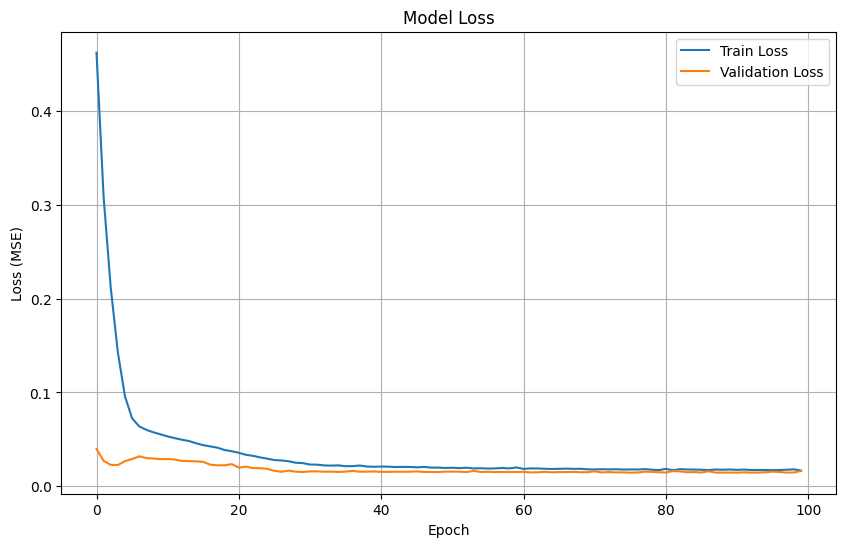

In [ ]:
# Visualización de la loss function durante el entrenamiento
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

###Parte 5: Medir la performance del modelo
Ahora estamos en condiciones de hacer una predicción

In [ ]:
### @TODO
# Hacer la predicción con el modelo entrenado
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


Se debería obtener un error sobre los datos de entrenamiento como de test menor al 2%. Si no se consigue este valor, se puede aumentar el número de epochs y re-entrenar el modelo o ajustar el tamaño del batch. Estudiar en la documentación que otros hiper-parámetros se pueden modificar para mejorar la precisión.

In [ ]:
# Medir la precisión
training_error = model.evaluate(X_train, y_train, verbose=0)
print('Error de entrenamiento = {:.2f}% '.format(training_error*100))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('Error de test = {:.2f}%'.format(testing_error*100))


Error de entrenamiento = 1.75% 
Error de test = 1.63%


In [ ]:
# calculate root mean squared error
print('RMSE en entrenamiento = %.2f' % (np.sqrt(training_error)))
print('RMSE en test = %.2f' % (np.sqrt(testing_error)))

RMSE en entrenamiento = 0.13
RMSE en test = 0.13


#### Evaluación de los resultados
Un MSE menor del 2% nos indica que, en promedio, el cuadrado de la diferencia entre las predicciones y los valores reales es aproximadamente un 2%. En términos absolutos, la diferencia promedio entre las predicciones del modelo y los valores es un 0.13. Dado que mis datos oscilan entre -1 y 1, este parece ser un error pequeño en relación al rango de los datos.


Ahora grafiquemos los datos:

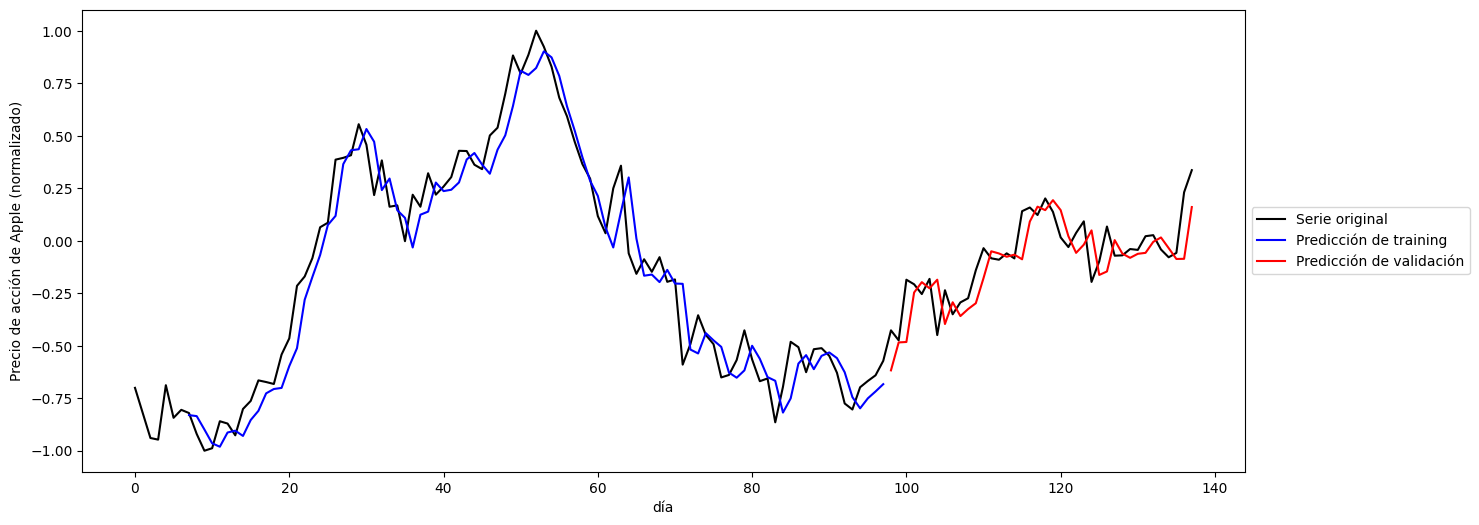

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 6))

# Graficar serie original
plt.plot(dataset,color = 'k')

# Graficar la predicción de entrenamiento
split_pt = len(train_predict) + window_size
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# Graficar la predicción de validación
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# Agregar rótulos
plt.xlabel('día')
plt.ylabel('Precio de acción de Apple (normalizado)')
plt.legend(['Serie original','Predicción de training','Predicción de validación'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Nota:[Aquí](https://datamarket.com/data/list/?q=provider%3Atsdl) se pueden encontrar otras series ordenadas con las que probar

###  Parte 6: Puntos de mejora
A continuación listar o llevar adelante los puntos que se entiende pueden mejorar la solución alcanzada.

#### Detección de outliers


Tanto en el ajuste de una LSTM para la predicción de una serie de tiempo ordenada como en el ajuste de cualquier otro modelo es muy importante la consistencia de los datos, la exploración y el análisis de estos.


Esta es una serie simple que no parece presentar anomalías pero en muchos casos la presencia de los llamados "outliers" puede llegar a distorsionar los resultados. En el caso particular del ajuste de una red neuronal la presencia de datos atípicos puede llevar a la red a aprender patrones incorrectos y por lo tanto que las predicciones sean menos precisas. También puede llevar a la pérdida de generalización logrando resultados más pobres en el dataset de test.


Si bien la transformación de los datos en muchos casos ayuda a que estos valores no sean tan extremos, depende mucho del tipo de transformación que se aplique. Min-max Scaler no necesariamente mitiga este problema por cómo está construido este transformador.


Para la detección e imputación de los outliers existen muchas soluciones posibles una de ellas es utilizar los quantiles o la desviación estándar, por ejemplo y aquellos valores que sean superiores al umbral establecido se imputan con este valor.


Si bien esta es una alternativa a tener en cuenta no se aplica sobre los datos ya que a simple vista no parece haber datos anómalos.


#### Ajuste de hiperparámetros
El resultado de las predicciones en este modelo fueron muy buenas pero esto no siempre sucede. Existen varias alternativas para mejorar el ajuste de un modelo y una de ellas es el **tuneo de hiperparámetros**, esto nos permite encontrar el modelo que produce mejores predicciones. Para resolver esta parte se utilizó un bucle for pero se podría haber utilizado GridSerachCV y KerasRegressor de scikit_learn.


Este es un ejercicio para ver cómo cambia el resultado según los diferentes parámetros pero se podría haber ajustado el bucle for para que guarde solo el modelo con el mejor resultado, con una comparación de métricas.


Se decide probar el ajuste del batch_size y las epochs pero también se podría haber ajustado el window_size y el learning_rate, por ejemplo.


In [ ]:
# Creamos el modelo
def LSTM_model(learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(5, input_shape=(window_size, 1)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [ ]:
# Definimos el rango de hiperparámetros para el "grid search"
batch_sizes = [1, 5, 7, 10]
epochs_list = [75, 100, 120, 150]

In [ ]:
# Dataframe para guardar los resultados
results = []

# Bucle para el "grid search"
for batch_size in batch_sizes:
  for epochs in epochs_list:
    print(f"Training with batch_size={batch_size} and epochs={epochs}")

    #Creamos el modelo
    model = LSTM_model(learning_rate=0.001)

    # Fit el modelo
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test), verbose=0)

    # Evaluacion en test
    y_pred = model.predict(X_test)
    # mse = mean_squared_error(y_test, y_pred)

    mse = model.evaluate(X_test, y_test, verbose=0)


    # Guardamos los resultados
    results.append({'batch_size': batch_size,
                    'epochs': epochs,
                    'mse': mse,
                    'history': history.history})

    print(f"Score (MSE) with batch_size={batch_size} and epochs={epochs}: {mse}")

Training with batch_size=1 and epochs=75
2/2 [==============================] - 0s 7ms/step
Score (MSE) with batch_size=1 and epochs=75: 0.014890889637172222
Training with batch_size=1 and epochs=100
2/2 [==============================] - 0s 7ms/step
Score (MSE) with batch_size=1 and epochs=100: 0.01633239910006523
Training with batch_size=1 and epochs=120
2/2 [==============================] - 1s 9ms/step
Score (MSE) with batch_size=1 and epochs=120: 0.01484938245266676
Training with batch_size=1 and epochs=150


2/2 [==============================] - 0s 8ms/step
Score (MSE) with batch_size=1 and epochs=150: 0.015229609794914722
Training with batch_size=5 and epochs=75


2/2 [==============================] - 0s 9ms/step
Score (MSE) with batch_size=5 and epochs=75: 0.014588323421776295
Training with batch_size=5 and epochs=100
2/2 [==============================] - 0s 7ms/step
Score (MSE) with batch_size=5 and epochs=100: 0.01523760985583067
Training with batch_size=5 and epochs=120
2/2 [==============================] - 1s 9ms/step
Score (MSE) with batch_size=5 and epochs=120: 0.014888348989188671
Training with batch_size=5 and epochs=150
2/2 [==============================] - 1s 7ms/step
Score (MSE) with batch_size=5 and epochs=150: 0.014185416512191296
Training with batch_size=7 and epochs=75
2/2 [==============================] - 1s 14ms/step
Score (MSE) with batch_size=7 and epochs=75: 0.01756153628230095
Training with batch_size=7 and epochs=100
2/2 [==============================] - 1s 8ms/step
Score (MSE) with batch_size=7 and epochs=100: 0.01542178075760603
Training with batch_size=7 and epochs=120
2/2 [==============================] - 1s 11m

In [ ]:
# Resultados de los modelos ajustados
results_df = pd.DataFrame(results)
results_df[['batch_size', 'epochs', 'mse']]

,batch_size,epochs,mse
0,1,75,0.014891
1,1,100,0.016332
2,1,120,0.014849
3,1,150,0.015230
4,5,75,0.014588
5,5,100,0.015238
6,5,120,0.014888
7,5,150,0.014185
8,7,75,0.017562
9,7,100,0.015422


In [ ]:
# Nos quedmos con el mejor modelo
best_model = results_df.loc[results_df['mse'].idxmin()]

print(f"Modelo con mejor socre (MSE): {best_model['mse']}")
print('RMSE en test  %.2f' % (np.sqrt(best_model['mse'])))
print(f"Parámetros del mejor modelo: batch_size={best_model['batch_size']}, epochs={best_model['epochs']}")


Modelo con mejor socre (MSE): 0.014185416512191296
RMSE en test  0.12
Parámetros del mejor modelo: batch_size=5, epochs=150


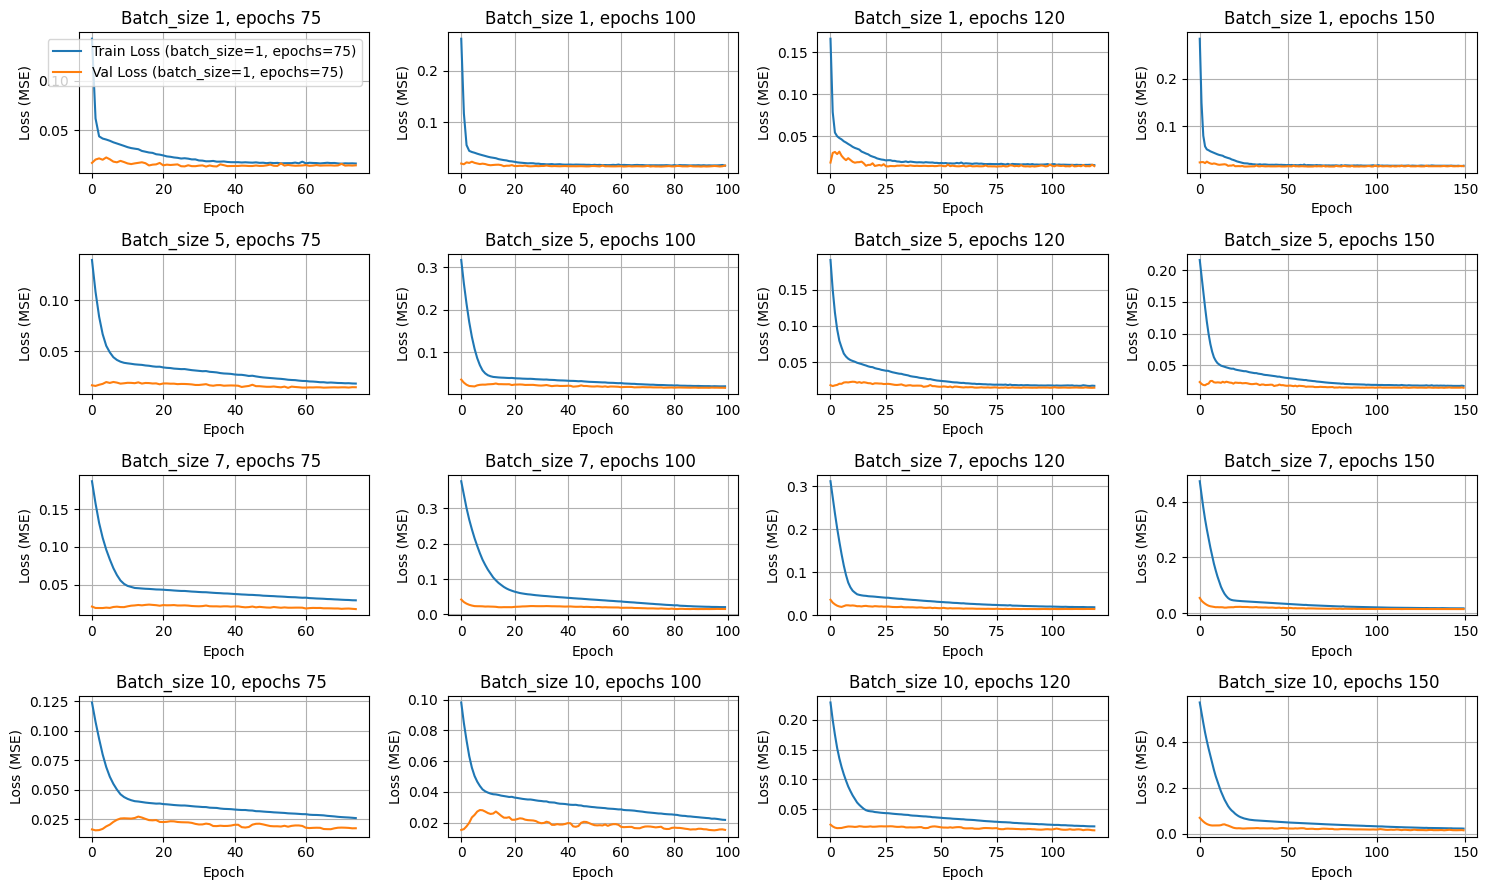

In [ ]:
# Definimos las dimensiones de la grilla
num_rows = 4
num_cols = 4

# Creamos la figura y especificamos el tamaño total
plt.figure(figsize=(15, 9))  # Ajusta el tamaño según tus preferencias

# Creamos subplots
for i, result in enumerate(results):

    history = result['history']
    label = f"batch_size={result['batch_size']}, epochs={result['epochs']}"

    # Calculamos la posición del subplot en la grilla
    plt.subplot(num_rows, num_cols, i + 1)

    # Graficamos la pérdida de entrenamiento y validación
    plt.plot(history['loss'], label=f"Train Loss ({label})")
    plt.plot(history['val_loss'], label=f"Val Loss ({label})")

    # Añadimos título y etiquetas de los ejes
    plt.title(f"Batch_size {result['batch_size']}, epochs {result['epochs']} ")
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')

    # Mostramos la leyenda solo en el primer subplot
    if i == 0:
        plt.legend(loc='upper right')

    # Activamos la cuadrícula en cada subplot
    plt.grid(True)

# Ajustamos automáticamente el espaciado entre subplots
plt.tight_layout()

# Mostramos la figura final con todos los subplots
plt.show()


En este gráfico podemos ver, tal como decíamos anteriormente, que un batch size más pequeño hace que la convergencia sea más rápida pero no siempre tiene los mejores resultados. En este caso el cambio en los resultados es mínimo pero como ejercicio está bueno experimentar para encontrar el mejor ajuste que en este caso fue con un batch size de 7, igual que el del window_size. También nos sirvió para darnos cuenta que no necesitamos epochs tan grandes.

#### Otras altenativas en la construcción de la red neuronal

Para la construcción de este modelo se decidió utilizar una única capa LSTM y los resultados fueron muy buenos pero en algunos casos apliar más de una capa puede ofrecer mejores resultados además de algunas ventajas. Las **capas adicionales** permiten capturar patrones más complejos. Las primeras layeres suelen capturar patrones de bajo nivel, mientras que las layeres superiores pueden identificar patrones más abstractos. Este ejemplo quizás no es tan complejo entonces no fue necesario pero podría ser una alternativa en caso de no obtener los resultados deseados.


Las capas adicionales además pueden ayudar a mejorar la capacidad del modelo para capturar dependencias más a largo plazo. Esto puede llegar a ser crucial en algunas series de tiempo donde eventos pasados pueden influir de manera muy significativa en los eventos futuros.


Hay que tener en cuenta que el agregado de layers adicionales también implica mayores costos computacionales por lo tanto si con una red simple se logra un buen ajuste no es necesario agregar más complejidad al modelo.


En el código a continuación se deja un ejemplo de como quedaría definido el modelo pero no se ajusta.


In [ ]:
#Crear el modelo secuencial
model = Sequential()
#Agregar una capa LSTM con 5 unidades ocultas y el input shape necesario
model.add(LSTM(5, input_shape=(window_size, 1), return_sequences=True))
# Segunda capa LSTM
model.add(LSTM(5))
#Agregar una capa densa con una unidad
model.add(Dense(1))

# Crear el modelo utilizando el optimizador recomendado por la documentación de keras
optimizer = Adam(learning_rate=0.001)

# Compilar el modelo con la función de pérdida requerida
model.compile(loss='mean_squared_error', optimizer=optimizer)

#### Forecasting Average - RNN vs Arima

Si bien las RNN y en particular LSTM logran buenos resultados en la predicción de las series de tiempo, en algunas bibliografías se menciona que el ajuste de modelos ARIMA traen incluso mejores resultados. Esto es siempre y cuando se cumplan con los supuestos que requieren este tipo de modelos. Estos son la estacionariedad, linealidad, ausencia de correlación en los residuos, normalidad de los residuos y varianza constante de los residuos. En muchos casos esto no se cumple y las LSTM no tienen ese requerimiento.


Teniendo esto en cuenta, una de las alternativas que se propone es usar ambos modelos y realizar un "Forecasting Average". La idea principal detrás del promedio de predicciones (o combinación de predicciones) es que los modelos no son capaces de capturar todos los patrones de variables particulares. Entonces, una combinación de predicciones puede producir errores de predicción menores que cualquiera de los pronósticos originales.


Ahora, qué se utiliza para hacer la combinación de las predicciones, en la literatura se han propuesto diferentes métodos, algunos de ellos son:


- Media simple: para cada observación se utiliza la media aritmética simple de los pronósticos. Por lo tanto, a cada pronóstico se le da el mismo peso.


- Mínimos cuadrados: bajo este enfoque, los pronósticos se comparan con los valores reales y los coeficientes de estas regresiones se utilizan como ponderaciones.


- Ponderaciones del error cuadrático medio: el error cuadrático medio de cada pronóstico se utiliza para formar ponderaciones de pronóstico individuales.


Este podría ser un enfoque a evaluar a la hora de explorar mejores resultados.


#### Bibliografía
- https://arxiv.org/pdf/2101.03087
- https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
- https://www.kaggle.com/code/ritesh7355/develop-lstm-models-for-time-series-forecasting
- https://keras.io/api/layers/recurrent_layers/lstm/